# Analysis Notebook
# A novel predictor of working memory performance: Sulcal depth in prefrontal cortex

This notebook denotes the code for the analysis and figures for the manuscript *A novel predictor of working memory performance: Sulcal depth in prefrontal cortex*. Code is adapted from Voorhies et al. 2021.

## Data ##
All data necessary for the analyses and figures is included in this repository.

This code utilizes data that has been cleaned and formatted. Please contact Jewelia Yao (jeweliayao@princeton.edu) if you have any questions about data retrieval, the data cleaning process, or would like access to raw data.

## Software Requirements ##
Please consult the README.txt file for specific package and version requirements.

## Setup

#### Python

In [ ]:
#import python packages 
import numpy as np
import pandas as pd
#import sklearn  for linear models
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold 
from sklearn import metrics
from sklearn import linear_model
from sklearn.utils import resample
loo = LeaveOneOut()
from math import log

### R

In [ ]:
#### setup rpy2 ####
# run once at start of session
%load_ext rpy2.ipython

In [ ]:
#### import robjects ####
import tzlocal
import rpy2.robjects 
from rpy2.robjects import r

In [ ]:
#### import rpackages ####

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f78c2d113c0> [RTYPES.NILSXP]

## Morphological Data
We include a sample function to extract morphological data (cortical thickness and sulcal depth) from cortical surface reconstructions. This step requires a Freesurfer directory and is not necessary to run the rest of the pipeline. The output from this step has been formatted as a .csv file and is included in the repository.

In [ ]:
def morphological_metrics(subjects_dir, sub_list, labels, outdir):
    '''
                          Sulcal Depth and Morphology script 
    OUTPUT: a CSV saved to project folder with minimum/maximum sulcal depth for each sulcal label (normalized to deepest point in hemisphere)
    Also includes formatted morphological stats from freesurfer command 'mris_anatomicals' (eg. cortical thickness, GM-volumen, surface area, curvature).
    REQUIREMENTS: 
        1) Run the following freesurfer commands on all subjects:
            a) recon-all
            b) mris_anatomicals for all labels of interest
            output should be nested in freesurfer label directory in the following format:
            .../<subject>/<label>/label_stats/<hemi>.<label>.label.stats.txt
            eg. sub_1/label/label_stats/lh.MFS.label.stats.txt
            
        2) A subjects list in a .txt file. 
        
        3) Labels created for sulcus of interest in the format
            .../<subject>/<label>/<hemi>.<sulcus>.label.
            eg. .../sub_1/label/rh.MFS.label. 
        All labels should have output from mris_anatomicals.
        Split annotation files with annot2label command
        
        4) nibable and nilearn must be installed and operational
        
    INPUT:  
    - subjects dir = path to freesurfer subjects directory
    - sub_list = path to subjects list text file
    - labels = alabels of interest as an array of strings eg. ['MFS', 'CoS', 'OTS']
    - outdir = path to output directory
    
    RETURNS:
    - dataframe with cortical thickness and sulcal depth for every sulcus for each subject. 
'''

############# pull metrics from mris_anatomicals output ################################

    def anatomicals_output (sub, hemi, label):
        ''' 
        reads in output from mris_anatomicals and organizes into a df
        Parameters
        -----------
        label: str
        Returns
        -------
        outputs from mris_anatomicals as an array
        '''
        # Pull metrics from label txt file for each label for every subject and append to df. 

        # label stats directory
        label_dir = subjects_dir + '/{}/label/'.format(sub)
        labels_stats = subjects_dir + '/{}/label/label_stats/'.format(sub)

        # extract cortical thickness, volume, surface area and curvature for each label
        label_filename = label_dir + '{}.{}.label'.format(hemi,label)
        label_stats_filename = labels_stats + '{}.{}.label.stats.txt'.format(hemi,label)
        label_data = surface.load_surf_data(label_filename)

        # open label stats text file and pull cortical thickness from the bottom line of the file. 
        with open(label_stats_filename) as f: 
            lastN = list(f)[-1:]
            label_stats = np.array(lastN[0].split()[3], dtype=float)

        return label_stats

################################## compute mean/max sulcal depth from surface file #####################################################
    def calc_depth(sub, hemi, label):
        ''''
        computes total mean, max sulcal depth and also mean/max depth as percentage of maximum depth in hemi
        Parameters
        ----------
        label: str
        Returns
        --------
        depth values as an array
        '''
        if sub == 'fsaverage':
            sulc_path = subjects_dir + '/fsaverage/surf/{}.smoothsulc'.format(hemi)
        else:
            sulc_path = subjects_dir + '/{}/surf/{}.sulc'.format(sub, hemi)
            sulc_data = surface.load_surf_data(sulc_path)

        # Load .sulc file for label vertices
        label_filename = label_dir + '{}.{}.label'.format(hemi,label)
        label_data = surface.load_surf_data(sulc_path)

        # calculate sulcal depth by mean label value in .sulc file
        label_mean_depth = np.mean(sulc_data[label_data])
        label_max_depth = np.amax(sulc_data[label_data])

        # calculate mean sulcal depth as a percentage of max depth in subject
        sulc_data_pct_max = sulcaldata/np.amax(sulc_data)
        label_mean_depth_pct_max = np.mean(sulc_data_pct_max[label_data])

        return np.array([label_mean_depth, label_max_depth, label_mean_depth_pct_max])


######################## Compute and organize sulcal morphology data into a CSV ###################################### 
     # set up CSV

    columns =  ['sub', 'hemi', 'label',  'cortical_thickness_mean', 
                                        'sulcal_depth_mean', 'sulcal_depth_max',
                                        'norm_mean_sulcal_depth']
    df_anatomical = pd.DataFrame(columns = columns)

    # Compute morphological metrics for each subject

    for sub_hemi in sub_hemi_combos:
        sub = sub_hemi[0]
        hemi = sub_hemi[-1]

        for label in labels:
            # extract cortical thickness, volume, surface area and curvature for each label
            anatomicals = anatomicals_output(sub, hemi, label)

            # compute sulcal depth
            depth = calc_depth(sub, hemi, label)

            # append metrics to dataframe
            label_stats = np.append(anatomicals, depth)
            descriptives = [sub, hemi, label]
            df_row = pd.DataFrame([descriptvies + list(label_stats)], columns = columns)
            df_anatomical = pd.concat([df_anatomical, df_row], axis=0)

    # return a dataframe with all morphological metrics
    return df_anatomical

## Morphological Analyses
### Does sulcal depth differ by WM region (DLPFC, VLPFC) and/or hemisphere?

In [ ]:
%%R
### load the data ###
anova_mean = read.csv('anova_mean_sulcal_depth.csv')
anova_std = read.csv('anova_std_sulcal_depth.csv')

#### rm-ANOVA: Mean Sulcal Depth

##### Sulcal depth differs by WM region.

In [ ]:
%%R
DLPFC_VLPFC_mean.aov <-  aov(norm_mean_sulcal_depth ~ region * hemi + Error(sub/(region * hemi)), anova_mean)
summary(DLPFC_VLPFC_mean.aov)


Error: sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 56  1.343 0.02398               

Error: sub:region
          Df Sum Sq Mean Sq F value Pr(>F)    
region     1  6.999   6.999   295.7 <2e-16 ***
Residuals 56  1.325   0.024                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: sub:hemi
          Df Sum Sq Mean Sq F value Pr(>F)
hemi       1 0.0253 0.02532    1.84   0.18
Residuals 56 0.7707 0.01376               

Error: sub:region:hemi
            Df Sum Sq  Mean Sq F value Pr(>F)
region:hemi  1 0.0043 0.004321   0.263   0.61
Residuals   56 0.9206 0.016439               

Error: Within
            Df Sum Sq Mean Sq F value Pr(>F)
Residuals 1368  40.92 0.02991               


##### Sulci in VLPFC are shallower than sulci in DLPFC.

In [ ]:
%%R
aggregate(x = anova_mean$norm_mean_sulcal_depth, 
          by = list(anova_mean$region),              
          FUN = mean)                          

##### rm-ANOVA: Standard Deviation of Mean Sulcal Depth

##### Standard deviation of sulcal depth differs by WM region.

In [ ]:
%%R
DLPFC_VLPFC_std.aov <-  aov(norm_std_sulcal_depth ~ region * hemi + Error(sub/(region * hemi)), anova_std)
summary(DLPFC_VLPFC_std.aov)

##### Sulcal depth is more variable in VLPFC than DLPFC

In [ ]:
%%R
aggregate(x = anova_mean$norm_mean_sulcal_depth, 
          by = list(anova_mean$region),              
          FUN = sd)   

### Figure 2: Plotting sulcal depth in DLPFC v VLPFC

##### Left Hemisphere

In [ ]:
%%R
library("ggplot2")

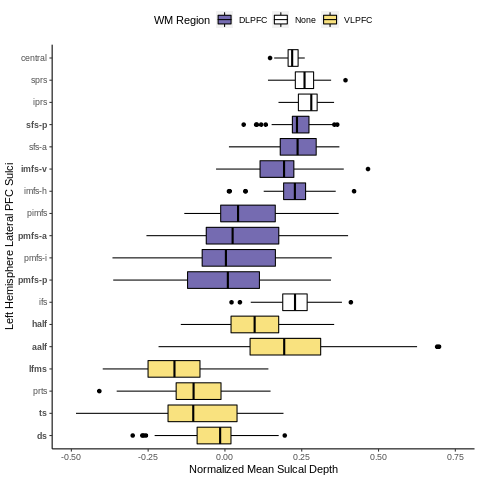

In [ ]:
%%R
lh_depth = read.csv('figures/lh_depth.csv')

ggplot(lh_depth, aes (label, sulcal_depth_mean_pct, fill = WM)) +
  geom_boxplot(color="black") + 
  coord_flip() + 
  scale_x_discrete(limits=c("ds", "ts", "prts", "lfms", "aalf", "half", "ifs", "pmfs-p", "pmfs-i", "pmfs-a", "pimfs", "imfs-h", "imfs-v", "sfs-a", "sfs-p","iprs","sprs", "central")) +
  labs(x = "Left Hemisphere Lateral PFC Sulci", y = "Normalized Mean Sulcal Depth") + 
  theme(axis.text.y = element_text(face = c('bold', 'bold', 'plain', 'bold', 'bold','bold','plain', 'bold',  'plain', 'bold', 'plain', 'plain', 'bold',  'plain',  'bold', 'plain', 'plain', 'plain')),
        axis.line = element_line(colour = "black"),
        panel.background = element_blank(),
        legend.position = "top") + 
  scale_fill_manual(name = "WM Region", labels = c("DLPFC", "None", "VLPFC"), values = c("#756bb1", "#FFFFFF","#f9e27f")) + 
  scale_y_continuous(limits=c(-0.50, 0.75), seq(-0.50,0.75,by=0.25), name="Normalized Mean Sulcal Depth")

##### Right Hemisphere

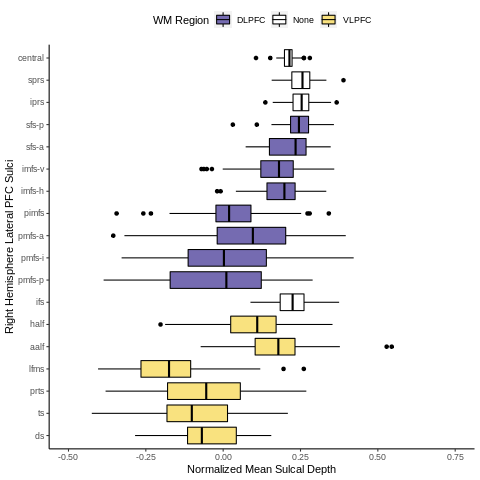

In [ ]:
%%R
rh_depth = read.csv('figures/rh_depth.csv')

ggplot(rh_depth, aes (label, sulcal_depth_mean_pct, fill = WM)) +
  geom_boxplot(color="black") + 
  coord_flip() + 
  scale_x_discrete(limits=c("ds", "ts", "prts", "lfms", "aalf", "half", "ifs", "pmfs-p", "pmfs-i", "pmfs-a", "pimfs", "imfs-h", "imfs-v", "sfs-a", "sfs-p","iprs","sprs", "central")) +
  labs(x = "Right Hemisphere Lateral PFC Sulci", y = "Normalized Mean Sulcal Depth") + 
  theme(axis.text.y = element_text(face = c('plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain', 'plain')),
        axis.line = element_line(colour = "black"),
        panel.background = element_blank(), 
        legend.position = "top") + 
  scale_fill_manual(name = "WM Region", labels = c("DLPFC", "None", "VLPFC"), values = c("#756bb1", "#FFFFFF","#f9e27f")) + 
  scale_y_continuous(limits=c(-0.50, 0.75), seq(-0.50,0.75,by=0.25), name="Normalized Mean Sulcal Depth")

## Morphology x Behavior Analyses

### Model Selection
### Does sulcal depth predict scores on Digits Forward and/or Digits Backward?
We use a LASSO regression as a form of feature selction to determine which sulci, if any, predcit WM performance. We use cross-validation to tune the shrinking parameter (alpha) and select the model that minimizes cross-validated mean squared error.

In [ ]:
 # load in dataframe
data = pd.read_csv('sulcal_depth.csv')

# subset by hemi 
lh_data = data.loc[data["hemi"]=="lh"]
rh_data = data.loc[data["hemi"]=="rh"]

#### LASSO Setup
##### Predictors: sulci in PFC + age at time of assessment

In [ ]:
X = ['central','ds','ts','prts','lfms','aalf','half','sprs', 'iprs','sfs-a', 'sfs-p', 'ifs', 
               'imfs-v', 'imfs-h', 'pmfs-p','pmfs-i', 'pmfs-a', 'pimfs','AssessmentAge']
Xage= ['AssessmentAge']

##### Dependent Variables: WM tasks - Digit Span

In [ ]:
yr1 = ['DigitsForward']
yr2 = ['DigitsBackward']

##### Alpha Values

In [ ]:
alphas = [1, 0.7, 0.5, 0.3, 0.1, 0.07, 0.05, 0.03, 0.01]

##### LASSO Regression

In [ ]:
def lm_lasso (Xr, yr, alpha = 0):
    """
    Willa Voorhies 07/25/2019.
    Performs a linear regression with a leave-one-subject out cross validation proceedure. 
    input: input: 
    Xr = matrix or array of predictors from dataframe  in format X= df[['X1', 'X2', 'Xn']]
    yr = Array of DV of interest from dataframe in format y= df['yr']
    returns: r_squared-cv, mean squared error.

    """
    np.random.seed(342)
    ytests = []
    ypreds = []
    X_array = np.array(Xr)
    y_array = np.array(yr)
    
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        lm = linear_model.Lasso(alpha) #Model to fit
        model = lm.fit(X_train,y_train) #Fit the model with the training data
        y_pred = lm.predict(X_test) #Generate predictions with your testing data using the above model

    #Append each score to respective lists.
        
        ytests += list(y_test)
        ypreds += list(y_pred)

    #Get mean squared error and R2-cv values by comparing the test to the predicted.       
    rr = metrics.r2_score(ytests, ypreds)
    ms_error = metrics.mean_squared_error(ytests, ypreds)
    return rr, ms_error, lm.coef_ 

In [ ]:
def best_model(Xr, yr, alphas):
    MSE = []
    Rsq = []
    coefs = []
    for alpha in alphas:
        mod = lm_lasso(Xr, yr, alpha)
        MSE.append(mod[1])
        Rsq.append(mod[0])
        coefs.append(mod[2])

    #Find the lowest value in the MSE array
    lowest_alpha = min(MSE)

    #Find the index of the lowest MSE
    lowest_MSE = MSE.index(lowest_alpha)
    
    alpha = alphas[lowest_MSE]
    MSE = MSE[lowest_MSE]
    coefs = coefs[lowest_MSE]
    
    return alpha, MSE, coefs

#### Correlation between Digits Backward and Digits Forward Scores

In [ ]:
%%R
# Correlate Digits Backward and Digits Forward
Backward_Forward_corr = cor.test(lh_data$DigitsBackward, lh_data$DigitsForward)
Backward_Forward_corr

UsageError: Cell magic `%%R` not found.


Digits Backward and Digits Forward are correlated.

### Digits Backward - Left Hemisphere x Sulcal Depth (+ age)

In [ ]:
Backward_LH = best_model(lh_data[X], lh_data[yr2], alphas)

###### Which alpha value provides the best fit model (lowest MSE)?

In [ ]:
# Set variables
Xr = lh_data[X]
yr = lh_data[yr2]

MSE = []
Rsq = []
coefs = []
test = []
pred = []
for alpha in alphas:
    mod = lm_lasso(Xr, yr, alpha)
    MSE.append(mod[1])
    Rsq.append(mod[0])
    coefs.append(mod[2])
    test.append(mod[3])
    pred.append(mod[4])

#Find the lowest value in the MSE array
Backwards_LH_MSE = min(MSE)

#Find the index of the lowest MSE
lowest_MSE = MSE.index(Backwards_LH_MSE)

In [ ]:
# Alpha
print(Backward_LH[0])

# MSE
print(Backward_LH[1])

0.01
2.6068037353376936


###### Which sulcis' depths predict Digits Backward scores in the left hemisphere?

In [ ]:
# Beta Values
print(Backward_LH[2])

[-0.          2.71733094 -0.09410522 -0.          2.84409793  2.81246469
 -2.73799673  0.          0.          0.         -4.28506431 -0.
 -1.5383112  -0.         -0.4133461   0.         -0.55318442  0.
  0.35159433]


The depths of the ds, ts, lfms, aalf, half, sfs-p, imfs-v, pmfs-p, and pmfs-a predict Digits Backwards scores.
Age was also included in the model and predicts scores as well.

### Digits Backward - Right Hemisphere x Sulcal Depth (+ age)

In [ ]:
Backward_RH = best_model(rh_data[X], rh_data[yr2], alphas)

###### Which alpha value provides the best fit model (lowest MSE)?

In [ ]:
# Alpha
print(Backward_RH[0])

# MSE
print(Backward_RH[1])

0.1
3.215951197527894


###### Which sulcis' depths predict Digits Backward scores in the right hemisphere?

In [ ]:
# Beta Values
print(Backward_RH[2])

[-0.          0.          0.         -0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.33200216]


Sulcal depth does not predict Digits Backward in the right hemisphere.

### Digits Forward - Left Hemisphere x Sulcal Depth (+ age)

In [ ]:
Forward_LH = best_model(lh_data[X], lh_data[yr1], alphas)

###### Which alpha value provides the best fit model (lowest MSE)?

In [ ]:
# Alpha
print(Forward_LH[0])

# MSE
print(Forward_LH[1])

0.07
3.2065822937497863


###### Which sulcis' depths predict Digits Backward scores in the left hemisphere?

In [ ]:
# Beta Values
print(Forward_LH[2])

[-0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.         -0.          0.
  0.33913754]


Sulcal depth does not predict Digits Forward in the left hemisphere.

### Digits Backward - Right Hemisphere x Sulcal Depth (+ age)

In [ ]:
Forward_RH = best_model(rh_data[X], rh_data[yr1], alphas)

###### Which alpha value provides the best fit model (lowest MSE)?

In [ ]:
# Alpha
print(Forward_RH[0])

# MSE
print(Forward_RH[1])

0.07
3.2065822937497863


###### Which sulcis' depths predict Digits Backward scores in the right hemisphere?

In [ ]:
# Beta Values
print(Forward_RH[2])

[ 0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.
  0.33913754]


Sulcal depth does not predict Digits Forward in the right hemisphere.

### Selected Model: The depths of 9 sulci predicts Digits Backward scores, as shown by the sulci selection process.

#### What is the relationship between the scores predicted by the model and the actual scores on the task?

In [ ]:
%%R
#load in scores dataframe
scores = read.csv('LHbackward_scores.csv')

In [ ]:
%%R
#Correlate the measured and predicted scores
scores_corr = cor.test(scores$Measured, scores$Predicted, method=c("spearman"))
scores_corr

UsageError: Cell magic `%%R` not found.


### Visualization - Figure 3c: Correlation between measured and predicted scores for the LHem Backward Model

R[write to console]: `geom_smooth()` using formula 'y ~ x'



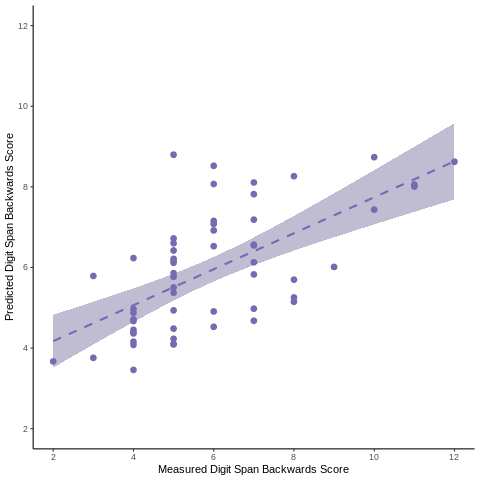

In [ ]:
%%R
ggplot(scores, aes(Measured, Predicted)) +
  geom_smooth(aes(y=Predicted),method="lm", se=TRUE,color="#756bb1", alpha=0.7, 
              linetype="dashed", size=1, fill = "#a5a1bf") +
  geom_point(shape = 19, size=2.5, show.legend = TRUE,  color="#756bb1") + 
  ylab("Predicted Digit Span Backwards Score") +
  xlab("Measured Digit Span Backwards Score") +  
  theme(axis.line = element_line(colour = "black"), panel.background = element_blank()) +
  scale_y_continuous(limits = c(2, 12), breaks=seq(0, 12, 2)) + 
  scale_x_continuous(limits = c(2, 12), breaks=seq(0, 12, 2)) 

##  Model Comparison - Age, All Sulci, or Selected Sulci?

Sulcal depth of a subset of LPFC sulci predicts Digits Backward scores. Does the depth of all sulci or age alone better predict scores?

###### Does age alone better predict Digits Backward scores?

#### Correlation between Digits Backward and Age

In [ ]:
%%R
# Correlate Digits Backward and Digits Forward
Backward_Age_corr = cor.test(lh_data$DigitsBackward, lh_data$AssessmentAge)
Backward_Age_corr

UsageError: Cell magic `%%R` not found.


Digits Backward and Age are positively correalated.

##### Digits Backward and age are positively correlated, but is age alone a better predictor?

In [ ]:
age_alone = lm_lasso(lh_data[Xage], lh_data[yr2], alpha)

/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.835823021165, tolerance: 0.02445535714285715
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.63140883991129, tolerance: 0.

In [ ]:
# R-squared, MSE
print(age_alone[0], age_alone[1])

0.2543177515575453 3.214535417570028


Though age is correlated with Digits Backwards scores, the model with age alone predicting Digits Backward scores has a higher MSE than the selected sulci model. Age alone does not better predict scores.

##### Does knowing the depth of all left hemisphere LPFC sulci better predict Digits Backward scores?

In [ ]:
all_sulci = lm_lasso(lh_data[X], lh_data[yr2], alpha)

/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.13515224065821, tolerance: 0.02445535714285715
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.08906059170018, tolerance: 

In [ ]:
# R-squared, MSE
print(all_sulci[0], all_sulci[1])

0.16343932928214355 3.6063000166433663


A model with all left hemisphere sulci predicting Digits Backward scores has a higher MSE than the selected sulci model. The depths of all sulci do not better predict scores.

### Figure 3 - Model selection and model comparison

##### Figure 3a,b: Model Selection - LASSO regressioin, which alpha has the lowest MSE?

##### Betas by alpha value:

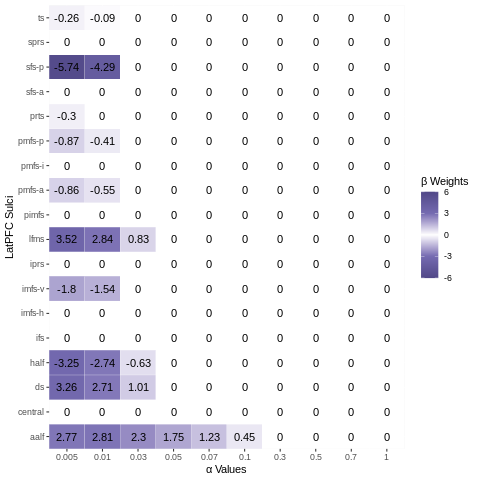

In [ ]:
%%R
lh_alpha = read.csv('figures/lh_alpha.csv')
alpha_value <- factor(lh_alpha$alpha, labels = c(0.005,0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1))

ggplot(lh_alpha, aes(alpha_value, label, fill=coeff)) + 
  geom_tile(aes(fill=coeff), colour = "white") + 
  scale_fill_gradientn(colors=c("#514888", "#756bb1","white","#756bb1","#514888"), limits =c(-6.0,6.0)) +
  geom_text(aes(label=coeff)) +
  labs(fill="\u03b2 Weights") +
  scale_x_discrete(name = "\u03b1 Values", expand = c(0,0)) + 
  scale_y_discrete(name = "LatPFC Sulci", expand = c(0,0)) 

##### MSE by log(alpha value):

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



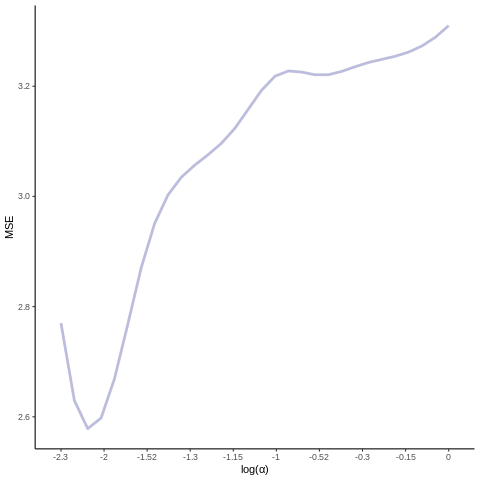

In [ ]:
%%R
lh_MSE = read.csv('figures/lh_MSE.csv')
lh_MSE$logalpha <- as.factor(lh_MSE$logalpha)
lh_MSE$MSE <- as.numeric(lh_MSE$MSE)
spline <- as.data.frame(spline(lh_MSE$logalpha, lh_MSE$MSE))

ggplot(lh_MSE, aes(logalpha,MSE)) + 
  geom_point(size=.02, colour="white") + 
  geom_smooth( color = "#bcbddc" , span = 0.99, se = FALSE, size = 4) + 
  geom_line(data = spline, aes(x = x, y = y), colour="#bcbddc", size=1.3) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"))+ 
  xlab("log(\u03b1)")

###### Figure 3d: Model Comparison - Which model (full, partial, age) is the best predictor of performance?

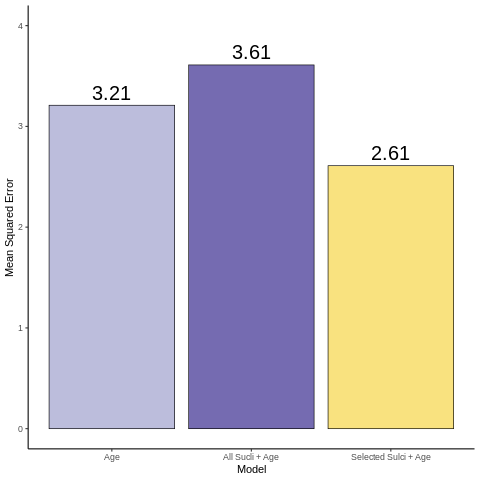

In [ ]:
%%R
LH_sulci_models = read.csv('figures/LH_sulci_models.csv')

ggplot(LH_sulci_models, aes(x=Model, y=Mean_Squared_Error, fill=Model))+
  geom_bar(stat = "identity",colour="black", size=0.3) + 
  geom_text(aes(label=Mean_Squared_Error), vjust=-.4, size=7) + 
  scale_fill_manual(values=c("#bcbddc", "#756bb1","#f9e27f")) +
  scale_y_continuous(limits = c(0, 4), breaks=seq(0, 4, 1)) +
  labs(x="Model" , y= "Mean Squared Error") +
  theme(axis.line = element_line(colour = "black"),
        panel.background = element_blank(),
        legend.position = "none")

### Cortical Thickness

##### Does the relationship between morphology and WM manipulation performance extend to features other than sulcal depth?

In [ ]:
#load in cortical thickness dataframe
ct = pd.read_csv('cortical_thickness.csv')
ct = ct.dropna()

# subset by hemi 
lh_ct = ct.loc[ct["hemi"]=="lh"]
rh_ct = ct.loc[ct["hemi"]=="rh"]

We test this using the 9 left hemisphere sulci from our sulcal depth model.

In [ ]:
Xct = lh_ct[['ds', 'ts', 'lfms', 'aalf', 'half', 'sfs-p', 'imfs-v', 'pmfs-p', 'pmfs-a','AssessmentAge']]
y = lh_ct['DigitsBackward']

In [ ]:
cortical_thickness = lm_lasso(Xct, y, 0)

/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.12686227796121, tolerance: 0.02445535714285715
  positive)
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/jkyao/anaconda3/envs/wmpfc/lib/python3.6/site-packages/sklear

In [ ]:
# R-squared, MSE
print(cortical_thickness[0], cortical_thickness[1])

0.04398968755513033 4.121231282272343


#### Use the Akaike Information Criterion (AIC) to assess whether cortical thickness or sulcal depth is a better predictor of Digits Backward

AIC is a relative measure. To assess the fit, we will compare the AIC value of the cortical thickness model to our sulcal depth model - with the 9 left hemisphere sulci included in each model. The model with the lowest AIC is better. To report a difference the difference in AIC must be > 2. A difference > 10 is considered substantial. 

In [ ]:
## AIC ##

def calculate_aic(n, mse, num_params):
    '''
    input:
    - n = num observations
    - mse =. mean squared error from regression
    - num_params = number of predictors in the model (including the intercept if applicable!)
    '''
    aic = n *log(mse) + 2 * num_params
    return aic

In [ ]:
ctMSE = cortical_thickness[1]
ctAIC = calc_aic(57, ctMSE, 10)

In [ ]:
sdMSE = Backward_LH[1]
sdAIC = calc_aic(57, sdMSE, 10)

In [ ]:
# Difference between the AICs
ctAIC - sdAIC

26.107546138560508

The sulcal depth model has a lower AIC, so it is a better predictor of Digits Backward. This difference is greater than 10, meaning that this is a substantial difference.